In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
path = "data/ml-latest-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

In [4]:
# The folder that contains movie + user data that analysis will be performed on.
ratings = pd.read_csv(path+'ratings.csv')
# The first rows show that the data consists of 4 columns()
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

In [6]:
# This is a way to access the name of the movie, for visualizing purposes.
# names_movies = pd.read_csv(path+'movies.csv')
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [7]:
# There are 9125 movies
len(movie_names)

9125

In [8]:
# Unique users and movies are deciphered to ensure that unnecessary noise is reduced.
users = ratings.userId.unique()
# There are 671 unique users
print(len(users))
movies = ratings.movieId.unique()
# There are 9066 unique movies.
print(len(movies))

671
9066


In [9]:
# Each unique user and movie is enumerated and individual user:index key values are generated. 
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [10]:
# User & movie IDs are updated such that they are
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [11]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
# Below, it is confirmed that there are 671 unique users
# And there are 9066 movies.
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [12]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

In [13]:
# Declaring and arbitrary number(50) that are the number of latent factors
# For creating each embedding.
n_factors = 50

In [14]:
# This allows for controlled randomness of the numbers.
np.random.seed = 42

In [15]:
# Data is split randomly between training and test data
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
# print(trn.head)
# 79866 training data
print(len(trn))
val = ratings[~msk]
# 20138 validation data
print(len(val))
# print(val.head)

80062
19942


In [16]:
# g grabs userId by rating and
g=ratings.groupby('userId')['rating'].count()
# then the top 15 users that watch the most movies.
topUsers=g.sort_values(ascending=False)[:15]
topUsers.head()

userId
546    2391
563    1868
623    1735
14     1700
72     1610
Name: rating, dtype: int64

In [17]:
# again, g is the variable that finds the movies that have been rated the most fequently
g=ratings.groupby('movieId')['rating'].count()
# These are the 15 most watched movies
topMovies=g.sort_values(ascending=False)[:15]
topMovies.head()

movieId
57     341
49     324
99     311
92     304
143    291
Name: rating, dtype: int64

In [18]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r.head()

,userId,movieId,rating,timestamp,rating_r
962,14,417,2.0,997938310,1700
963,14,650,2.0,1134521380,1700
964,14,651,4.5,1093070098,1700
965,14,652,4.0,1040205753,1700
966,14,20,3.0,1093028290,1700


In [19]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')
top_r.head()

,userId,movieId,rating,timestamp,rating_r,rating_r
962,14,417,2.0,997938310,1700,247
5048,29,417,4.0,944943070,1011,247
10214,72,417,5.0,1303464840,1610,247
28390,211,417,3.0,1218405007,876,247
29266,212,417,3.0,1462637445,910,247


In [20]:
# The crosstab shows great insight, and also it shows that users 
# 14, 29 and 72 have watched an rated every single movie.
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


In [21]:
# The most basic model is a dotproduct of the user embedding & the movie embedding.
# user_in is the input vector of the user
user_in = Input(shape=(1,), dtype='int64', name='user_in')
# u is/are the embeddings for each user. So, the inputs to the Emberdding() function are
# Embedding(671, 50, input_lenght=1, W_regularizer=l2(le-4))(user_in)
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
# The Embedding is a Tensor and is associated with Theano
print(type(u))

# The same as above, but this time for an input of each movie.
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)
# The Embedding is a Tensor and is associated with Theano and it is the movie embedding 
# That consists of 50 latent factors.
print(type(m))


<class 'theano.tensor.var.TensorVariable'>
<class 'theano.tensor.var.TensorVariable'>


In [22]:
# The dot product of the user and movie embeddings is calculated
x = merge([u, m], mode='dot')
# print(u)
# The dot product is then flattened into one contiguous vector
x = Flatten()(x)
# print(x)
# This is the model
model = Model([user_in, movie_in], x)
# A computational graph is created
model.compile(Adam(0.001), loss='mse')

# model.summary()

In [23]:
# The model is trained by provideing the userId & movieId as input and the raiting as the target valye
# It is ran for 6 epochs
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80062 samples, validate on 19942 samples
Epoch 1/6
80062/80062 [==============================] - 6s - loss: 9.8022 - val_loss: 3.7973
Epoch 2/6
80062/80062 [==============================] - 6s - loss: 3.1364 - val_loss: 1.9782
Epoch 3/6
80062/80062 [==============================] - 6s - loss: 2.4145 - val_loss: 1.6020
Epoch 4/6
80062/80062 [==============================] - 6s - loss: 2.2394 - val_loss: 1.4682
Epoch 5/6
80062/80062 [==============================] - 6s - loss: 2.1670 - val_loss: 1.4241
Epoch 6/6
80062/80062 [==============================] - 6s - loss: 2.1296 - val_loss: 1.3960


In [29]:
# Changing the learning rate to optimize more finely
model.optimizer.lr=0.01

In [25]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80062 samples, validate on 19942 samples
Epoch 1/6
80062/80062 [==============================] - 6s - loss: 2.1015 - val_loss: 1.3939
Epoch 2/6
80062/80062 [==============================] - 6s - loss: 2.0802 - val_loss: 1.3874
Epoch 3/6
80062/80062 [==============================] - 6s - loss: 2.0610 - val_loss: 1.3850
Epoch 4/6
80062/80062 [==============================] - 6s - loss: 2.0415 - val_loss: 1.3936
Epoch 5/6
80062/80062 [==============================] - 6s - loss: 2.0232 - val_loss: 1.3977
Epoch 6/6
80062/80062 [==============================] - 6s - loss: 2.0059 - val_loss: 1.3927


In [26]:
model.optimizer.lr=0.01

In [30]:
# Since this data has been tested far and wide, the closest benchmark is at
# a loss of 0.9, but I am doing considerably poorly. The next step will
# be a step to decrease that loss value.
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80062 samples, validate on 19942 samples
Epoch 1/6
80062/80062 [==============================] - 6s - loss: 1.8651 - val_loss: 1.4532
Epoch 2/6
80062/80062 [==============================] - 6s - loss: 1.8598 - val_loss: 1.4590
Epoch 3/6
80062/80062 [==============================] - 6s - loss: 1.8546 - val_loss: 1.4682
Epoch 4/6
80062/80062 [==============================] - 6s - loss: 1.8503 - val_loss: 1.4651
Epoch 5/6
80062/80062 [==============================] - 6s - loss: 1.8458 - val_loss: 1.4694
Epoch 6/6
80062/80062 [==============================] - 6s - loss: 1.8439 - val_loss: 1.4735


In [31]:
# In order to decrease the loss function further, biases are added for each movie
# and each user to represent how positive or negative each user is and how good a movie is.
# It is calculated by creating an embedding
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [32]:
# This outputs u, the user embedding(u) and the user_in as calculated by the embedding_input() function
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
# This outputs u, the user embedding(u) and the user_in
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [33]:
# A bias is created by creating an embedding with a single value
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [34]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [35]:
# After adding bias, the new model needs to add
# the user bias and the movie bias to improve accuracy.
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [36]:
# Achieved state of the art according to http://www.librec.net/example.html
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80062 samples, validate on 19942 samples
Epoch 1/6
80062/80062 [==============================] - 6s - loss: 8.7706 - val_loss: 3.0824
Epoch 2/6
80062/80062 [==============================] - 6s - loss: 2.5894 - val_loss: 1.6138
Epoch 3/6
80062/80062 [==============================] - 6s - loss: 2.0098 - val_loss: 1.3176
Epoch 4/6
80062/80062 [==============================] - 6s - loss: 1.8492 - val_loss: 1.2050
Epoch 5/6
80062/80062 [==============================] - 6s - loss: 1.7532 - val_loss: 1.1460
Epoch 6/6
80062/80062 [==============================] - 6s - loss: 1.6727 - val_loss: 1.1111


In [37]:
model.optimizer.lr=0.001

In [40]:
# 0.8345 validation loss and 0.84 training loss is the best I can do using collaborative filtering.
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80062 samples, validate on 19942 samples
Epoch 1/3
80062/80062 [==============================] - 6s - loss: 0.9250 - val_loss: 0.8562
Epoch 2/3
80062/80062 [==============================] - 6s - loss: 0.8813 - val_loss: 0.8465
Epoch 3/3
80062/80062 [==============================] - 6s - loss: 0.8402 - val_loss: 0.8345


In [41]:
model.save_weights(model_path+'bias_final_CF.h5')

In [42]:
model.load_weights(model_path+'bias_final_CF.h5')

In [43]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.9691]], dtype=float32)

In [44]:
# Result analysis
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

In [45]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

In [46]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.26450127, 'Battlefield Earth (2000)'),
 (-0.17702918, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.018325489, 'Police Academy 6: City Under Siege (1989)'),
 (-0.0016665257, 'Jaws 3-D (1983)'),
 (0.0069621252, 'Little Nicky (2000)'),
 (0.014970213, 'Blair Witch Project, The (1999)'),
 (0.024506204, 'Blame It on Rio (1984)'),
 (0.042817961, 'Blade: Trinity (2004)'),
 (0.079255015, 'Batman & Robin (1997)'),
 (0.079666071, 'Road to Wellville, The (1994)'),
 (0.079781651, 'Super Mario Bros. (1993)'),
 (0.085219406, 'Speed 2: Cruise Control (1997)'),
 (0.094481088, 'Spice World (1997)'),
 (0.10549266, 'Wild Wild West (1999)'),
 (0.12086059, 'Police Academy 5: Assignment: Miami Beach (1988)')]

In [48]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.3204684, 'When We Were Kings (1996)'),
 (1.3125229, 'Man Who Shot Liberty Valance, The (1962)'),
 (1.3043088, 'Rush (2013)'),
 (1.2422693, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.2398483, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.2391152, '3:10 to Yuma (2007)'),
 (1.2374371, 'Shawshank Redemption, The (1994)'),
 (1.2217622, 'Captain America: The Winter Soldier (2014)'),
 (1.2011055, 'Gold Rush, The (1925)'),
 (1.1962793,
  "Monty Python's And Now for Something Completely Different (1971)"),
 (1.1901209,
  'Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)'),
 (1.1724453, 'Cyrano de Bergerac (1990)'),
 (1.1710409, 'The Theory of Everything (2014)'),
 (1.1698643, 'You Can Count on Me (2000)'),
 (1.1662244, '12 Years a Slave (2013)')]

In [49]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
# This is a 2000, 50 matrix because we are looking at
# 50 embeddings each for 2000 movies.
movie_emb.shape

(2000, 50)

In [51]:
# Principal Component Analysis is done to make sense of the embeddings.
from sklearn.decomposition import PCA
# The data is reduced to a 3 vectors space
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [52]:
# This is the first vector
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac0, topMovies)]

In [53]:
# This vector retrieves the flop movies
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.0099383909, 'Blade: Trinity (2004)'),
 (0.0070492649, 'Battlefield Earth (2000)'),
 (0.0070144664, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (0.0067117023, 'Howard the Duck (1986)'),
 (0.0061522638, 'Jaws 3-D (1983)'),
 (0.0052911337, 'Divergent (2014)'),
 (0.00508792, 'Grease 2 (1982)'),
 (0.00437184, 'Police Academy 3: Back in Training (1986)'),
 (0.0043295794, 'Anaconda (1997)'),
 (0.0043097129, 'House on Haunted Hill (1999)')]

In [54]:
# This is the opposite of Flop, these are cult classics!
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.047258887, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.045909788, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.045555394, 'Shawshank Redemption, The (1994)'),
 (-0.045104116, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (-0.045071334, 'Silence of the Lambs, The (1991)'),
 (-0.044674467, 'Big Fish (2003)'),
 (-0.044426948, 'Toy Story (1995)'),
 (-0.044421215, 'Usual Suspects, The (1995)'),
 (-0.044298757, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.043852214, 'American Beauty (1999)')]

In [55]:
# This is the 2nd vector retrieved by PCA analysis
fac1 = movie_pca[1]

In [56]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

# At one end of the spectrum of this vector there are dialog heavy movies
# like Lost in Translation
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.067168698, '2001: A Space Odyssey (1968)'),
 (0.064403415, 'City Lights (1931)'),
 (0.063366637, 'Clockwork Orange, A (1971)'),
 (0.059264302, 'Lost in Translation (2003)'),
 (0.058141712, 'Big Lebowski, The (1998)'),
 (0.056284826, 'Apocalypse Now (1979)'),
 (0.056096628,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (0.055669937, 'Brokeback Mountain (2005)'),
 (0.05565, 'Chinatown (1974)'),
 (0.054215807, 'Vertigo (1958)')]

In [57]:
# The other end of the vector are movies high in special effects
# And fewer dialogues.
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10189676, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.081121482, 'Armageddon (1998)'),
 (-0.076443918, 'Stargate (1994)'),
 (-0.068880245, 'Batman Forever (1995)'),
 (-0.065819018, 'Twister (1996)'),
 (-0.065569729, 'Titanic (1997)'),
 (-0.064292647, 'Star Trek IV: The Voyage Home (1986)'),
 (-0.063782573, 'Waterworld (1995)'),
 (-0.062896021, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.062763773, 'Jurassic Park (1993)')]

In [59]:
fac2 = movie_pca[2]
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

In [60]:
# One end of the third vector showcases feel good romcoms vs violent/scary movies
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.086884469, 'Sleepless in Seattle (1993)'),
 (0.073520541, 'Casper (1995)'),
 (0.071590528, 'Nell (1994)'),
 (0.068331473, 'Mrs. Doubtfire (1993)'),
 (0.066899888, 'While You Were Sleeping (1995)'),
 (0.066136703, 'Postman, The (Postino, Il) (1994)'),
 (0.065792464, "Romy and Michele's High School Reunion (1997)"),
 (0.063806161, 'Room with a View, A (1986)'),
 (0.063474849, 'Four Weddings and a Funeral (1994)'),
 (0.061257947, 'Phenomenon (1996)')]

In [61]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.12093659, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.09993086, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.085696675, 'Matrix, The (1999)'),
 (-0.084663942, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.081679255, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.080916062, 'Dark Knight, The (2008)'),
 (-0.080553494, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.078652978, 'Aliens (1986)'),
 (-0.076602638, 'X-Men (2000)'),
 (-0.074778229, 'Mad Max: Fury Road (2015)')]

In [62]:
reload(sys)
sys.setdefaultencoding('utf8')

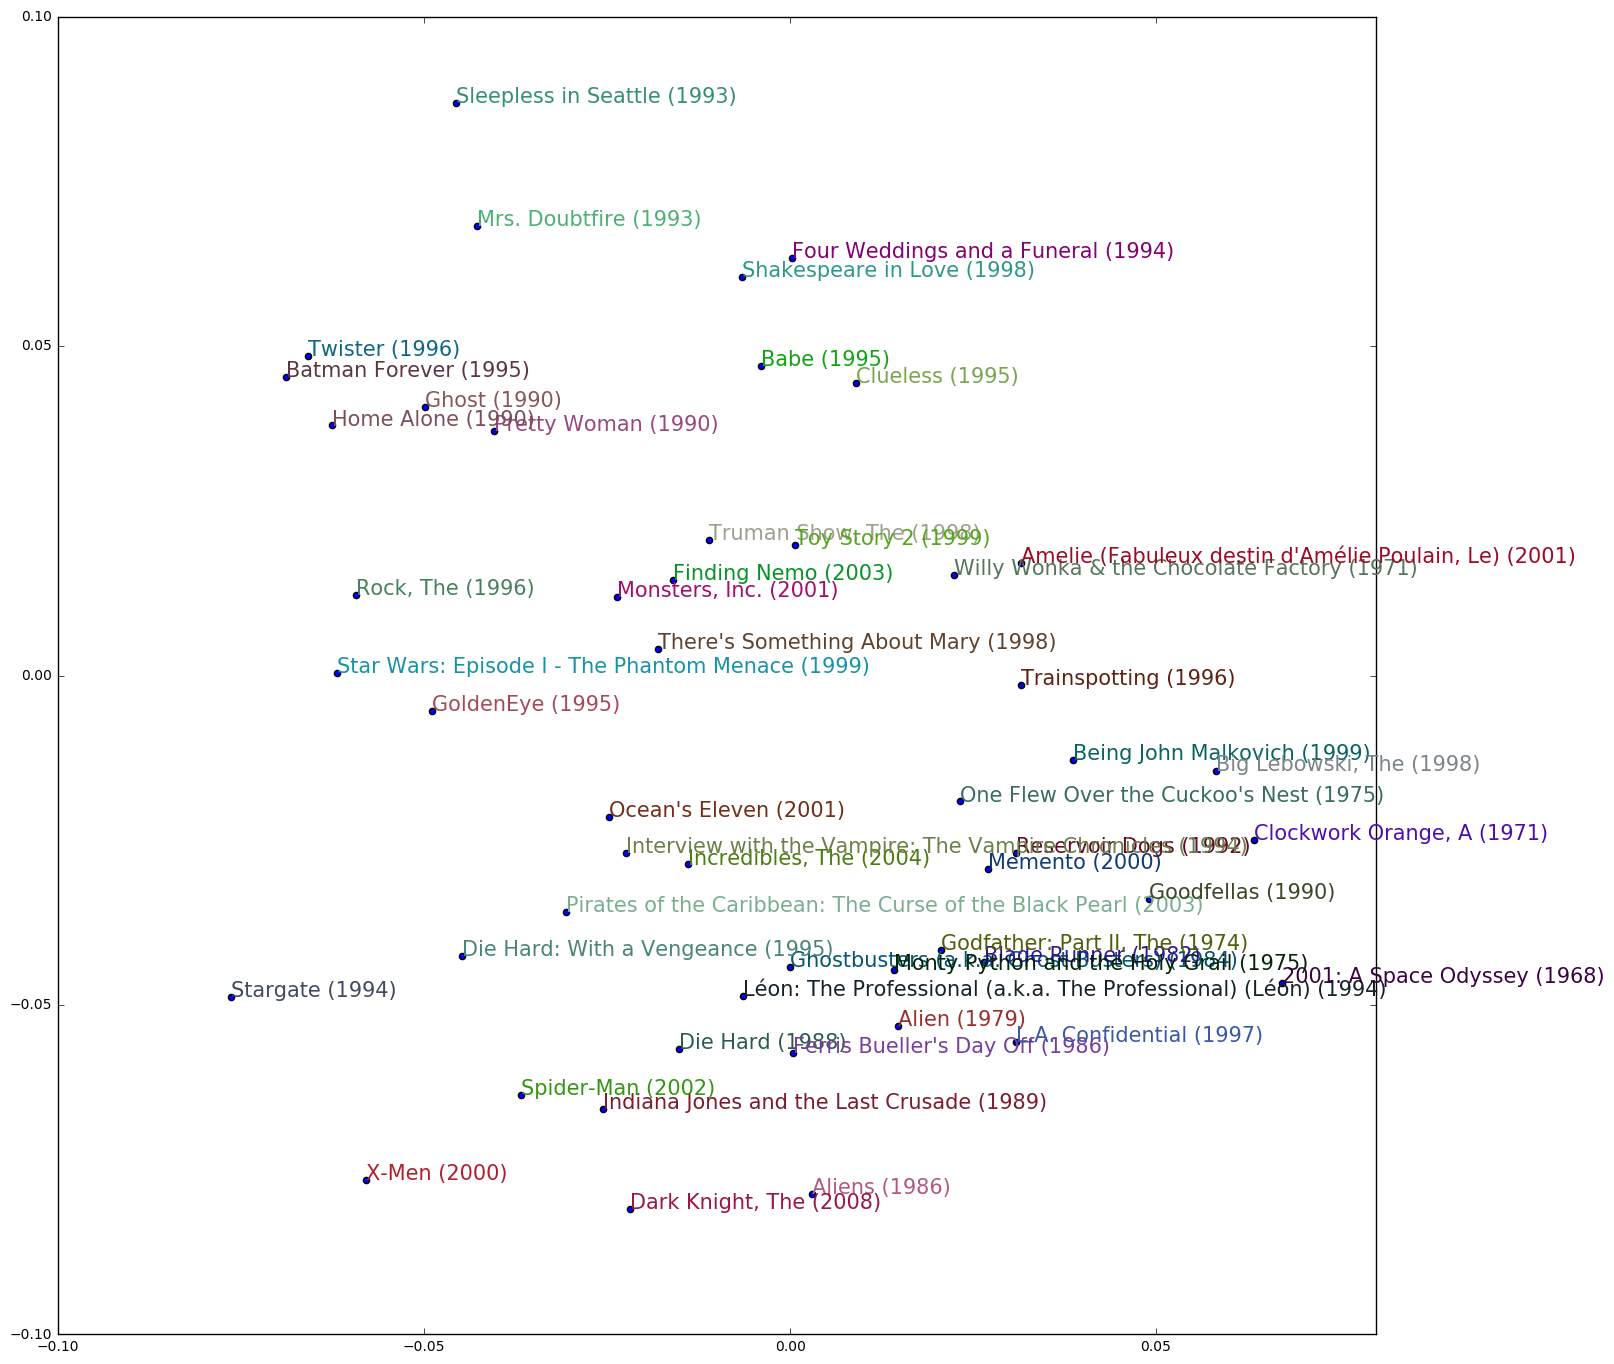

In [63]:
# Here is a plot comparing the 2nd and 3rd vectors from above.
start=50; end=100
X = fac1[start:end]
Y = fac2[start:end]
plt.figure(figsize=(17,17))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=15)
plt.show()

## Results

- Got great results that clearly show similar vector representations for similar movies.
- For example according to the graph, Babe and Clueless are very close together in the 2D space and it bodes accurately with real life too!

## Next, A neural net is implemented to compare accuracies agains the dot-prod + bias model above.

In [64]:
# Neural Network using the Keras Functional API

user_in, u = embedding_input('user_in', n_users, n_factors, 1e-5)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-5)

# User and movie embeddings are concated into a massive vector and then flattened
x = merge([u, m], mode='concat')
x = Flatten()(x)
# Dense layer
x = Dense(100, activation='relu')(x)
# Adding Dropout
x = Dropout(0.5)(x)
# Activation function 
x = Dense(1)(x)

nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [ ]:
# Just 6 epochs shatter the state of the art achieved by Stanford Researchers(0.89 loss). I achieved (0.8090 loss)
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, validation_data=([val.userId, val.movieId], val.rating))

In [44]:
model.save_weights(model_path+'bias3.h5')

In [45]:
model.load_weights(model_path + 'bias3.h5')

In [46]:
# If we look at the cross tab, this predicts that user 3 would really like movie 6.
model.predict([np.array([3]), np.array([6])])

array([[ 4.7108]], dtype=float32)